In [26]:
from units import *
import matplotlib.pyplot as plt
from astrometry_sim import QuasarSim
import healpy as hp
from pylab import cm as cmaps
from estimator_wholesky import get_vector_alm
from tqdm import *
from astropy import units as u

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
sim.rho_v_SHM(200*Kmps)

200196826.22774526

In [ ]:
max_sep = 10
nside = 128
lmax = 3*nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True, 
                sim_uniform=True, nside=nside, calc_powerspecs=True, 
                do_alpha=True)

sim.set_mass_distribution(sim.rho_M_SI, f_DM=0.5, M_min=1e5*M_s, M_max=1e10*M_s, alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1*kpc, R_max=260*kpc)
sim.set_subhalo_properties(sim.c200_Moline)

sim.analysis_pipeline()

In [15]:
cmap = cmaps.Greys
cmap.set_under('w')

In [16]:
maxx = 10**(-3.5)
maxx_a = 10**(-10.5)

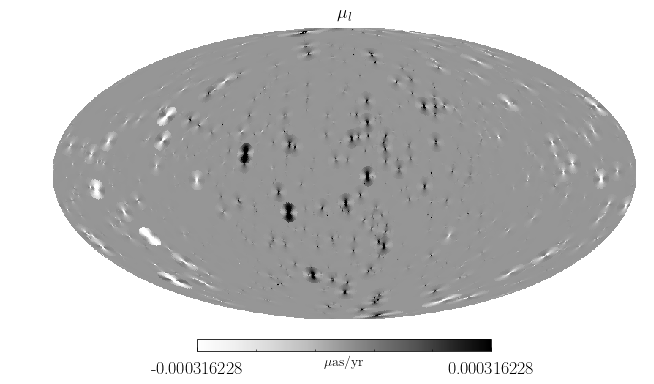

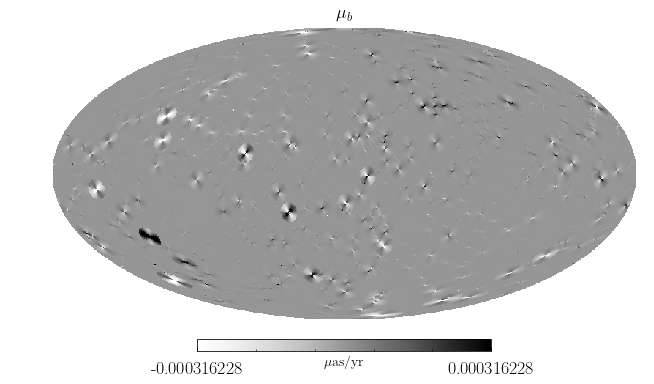

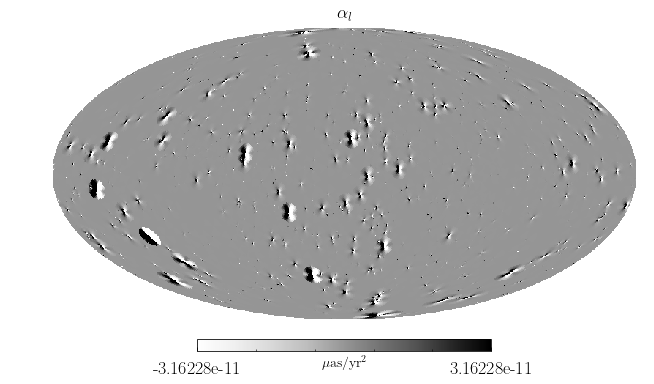

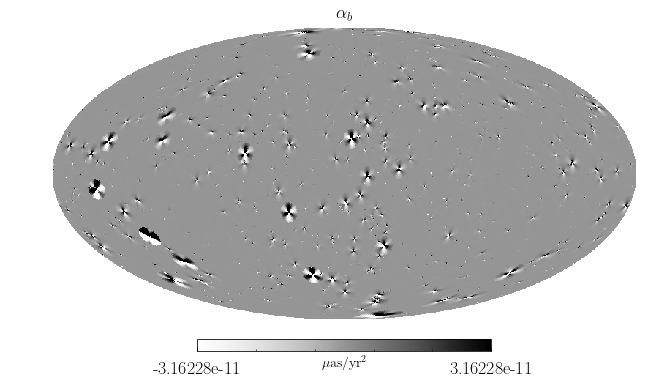

In [17]:
hp.mollview(1e6*sim.mu_qsrs[:,0],max=maxx, min=-maxx, title="$\mu_l$", unit='$\mu$as/yr', cmap=cmap)
hp.mollview(1e6*sim.mu_qsrs[:,1],max=maxx, min=-maxx, title="$\mu_b$", unit='$\mu$as/yr', cmap=cmap)
hp.mollview(1e6*sim.alpha_qsrs[:,0],max=maxx_a, min=-maxx_a, title="$\\alpha_l$", unit='$\mu$as/yr$^2$', cmap=cmap)
hp.mollview(1e6*sim.alpha_qsrs[:,1],max=maxx_a, min=-maxx_a, title="$\\alpha_b$", unit='$\mu$as/yr$^2$', cmap=cmap)

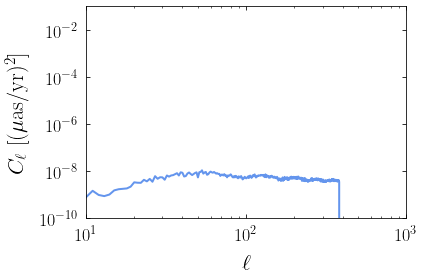

In [20]:
ell = np.arange(len(sim.Cl_B))

plt.plot(ell, ell*(ell+1)*(sim.Cl_B)/(2*ell + 1)/1e-12)

plt.yscale("log")
plt.xscale("log")
plt.xlim(10, 1000)
plt.ylim(1e-10,1e-1)
plt.ylabel("$C_\ell$ [($\mu$as/yr)$^2$]")
plt.xlabel("$\ell$")
plt.tight_layout()


In [84]:
lmin_plot = 0
lmax_plot = 300

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '$\\log_{10}(\\Psi_{lm}\\,[mas/yr])$')

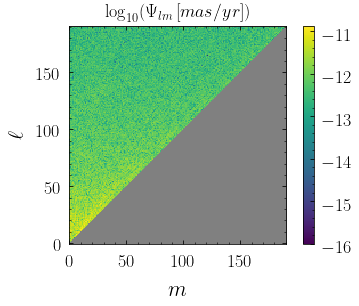

In [85]:
plt.imshow((np.log10(np.abs(sim[i].fB)[lmin_plot:lmax_plot,lmin_plot:lmax_plot])), origin='lower', vmin=-16)
cbar = plt.colorbar()

plt.xlabel("$m$")
plt.ylabel("$\ell$")

plt.title("$\log_{10}(\Psi_{lm}\,[mas/yr])$")

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


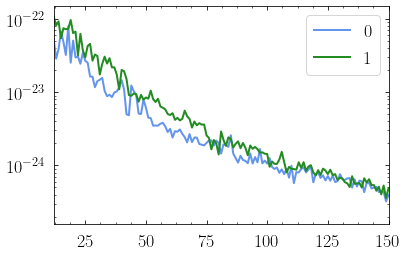

In [86]:
nch = 2
ch = np.transpose([[np.mean(split_ary) for split_ary in np.array_split((np.abs(sim[i].fB)**2)[l][:l], nch)] for l in range(lmax)])
ell = np.arange(len(ch[0]))

for ich in range(nch):
    plt.plot(ell, 2*ch[ich], label=str(ich))
# plt.plot(ell, 1e6*Cl_tot[1:]*ell*(ell+1), label="Tot", color='grey', alpha=0.9)

plt.legend()
plt.xlim((180/max_sep), 150)
# plt.ylim(1e-32,1e-27)
# plt.xscale("log")
plt.yscale("log")